In the other notebook: <span style= "color: blue">**Anomaly_detection**</span>, we discussed various way of handling data imbalances including Random oversampling or SMOTE. In this notebook, we will explore an alternative where certain ensemble models handle the class imbalance with in-built features.

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('train.csv')
df

,timestamp,value,is_anomaly,predicted
0,1425008573,42,False,44.072500
1,1425008873,41,False,50.709390
2,1425009173,41,False,81.405120
3,1425009473,61,False,39.950367
4,1425009773,44,False,35.350160
...,...,...,...,...
15825,1429756073,44,False,53.624115
15826,1429756373,45,False,59.752296
15827,1429756673,48,False,52.147630
15828,1429756973,26,False,58.007545


In [4]:
#Converting the datetime from integer to datetime unit
df['datetime']=pd.to_datetime(df['timestamp'], unit='s')
df['hour']=df['datetime'].apply(lambda x: x.hour)
df['day_of_week'] = df['datetime'].apply(lambda x: x.weekday())
df

,timestamp,value,is_anomaly,predicted,datetime,hour,day_of_week
0,1425008573,42,False,44.072500,2015-02-27 03:42:53,3,4
1,1425008873,41,False,50.709390,2015-02-27 03:47:53,3,4
2,1425009173,41,False,81.405120,2015-02-27 03:52:53,3,4
3,1425009473,61,False,39.950367,2015-02-27 03:57:53,3,4
4,1425009773,44,False,35.350160,2015-02-27 04:02:53,4,4
...,...,...,...,...,...,...,...
15825,1429756073,44,False,53.624115,2015-04-23 02:27:53,2,3
15826,1429756373,45,False,59.752296,2015-04-23 02:32:53,2,3
15827,1429756673,48,False,52.147630,2015-04-23 02:37:53,2,3
15828,1429756973,26,False,58.007545,2015-04-23 02:42:53,2,3


One way to handle class imbalance is using the <span style ="color: blue">**XGBClassifier**</span> with the 'scale_pos_weight' parameter. This parameter is specifially designed to address class imbalance in gradient boosting algorithms like XGBoost.

In binary classifiation, 'scale_pos_weight' is used to assign different weights to the positive and negative classes. The value is typically set to the ratio of the nember of negative class samples to the positive class. It helps in controlling the balance between precision and recall by giving more importance to the minority (anomaly) class.

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

In [6]:
class classifier_XGBoost:
    def __init__(self, X, y):
        self.X=X
        self.y=y
        self.pipeline= Pipeline([('scaler', StandardScaler()), ('classifier', XGBClassifier())])
        self.param_grid = {'classifier__n_estimators': [60, 80, 100], 'classifier__max_depth': [9, 10, 12], 'classifier__eta': [0.01, 0.03, 0.05], 'classifier__scale_pos_weight':[19, 20]}
        self.grid_search = GridSearchCV(self.pipeline, param_grid=self.param_grid, cv=5, scoring='f1')
    
    def fit_transform(self):
        return self.pipeline.fit_transform(self.X, self.y)
    
    def fit(self):
        self.grid_search.fit(self.X, self.y)
        self.pipeline = self.grid_search.best_estimator_
        return self.pipeline
    
    def transform(self, X_test):
        return self.pipeline.transform(X_test)
    
    def cross_val_score(self):
        score = cross_val_score(self.pipeline, self.X, self.y, cv=5, scoring='f1')
        return score
    
    def predict(self, X_test, threshold=0.5):
        proba = self.pipeline.predict_proba(X_test)[:,1]
        return (proba>threshold).astype(int)
    
X=df[['hour', 'day_of_week', 'timestamp', 'value', 'predicted']]
y=df[['is_anomaly']]
x_train,x_test,train_label,test_label=train_test_split(X,y,test_size=0.1,random_state=0)
classify = classifier_XGBoost(x_train, train_label)
classify.fit()

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eta=0.05,
                               eval_metric=None, feature_types=None, gamma=None,
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=12, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, ...))])

In [12]:
print('Best hypeparameter choices:', classify.grid_search.best_params_)
print('Cross validation score', classify.cross_val_score())

Best hypeparameter choices: {'classifier__eta': 0.05, 'classifier__max_depth': 12, 'classifier__n_estimators': 100, 'classifier__scale_pos_weight': 19}
Cross validation score [0.73103448 0.72108844 0.69453376 0.74074074 0.73015873]


In [9]:
y_pred = classify.predict(x_test)
y_int = test_label.astype(int)
y_int

,is_anomaly
3970,1
12210,0
11311,0
654,0
9763,1
...,...
14987,0
2095,0
11789,0
6525,0


In [11]:
from sklearn.metrics import confusion_matrix, classification_report
target_names = ['Normal', 'Anomaly']
# Evaluate the model
conf_matrix = confusion_matrix(test_label, y_pred, labels=[1, 0])
classification_rep = classification_report(test_label, y_pred, target_names=target_names)

# Print the confusion matrix and classification report
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_rep)

Confusion Matrix:
[[  58   22]
 [  18 1485]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99      1503
     Anomaly       0.76      0.72      0.74        80

    accuracy                           0.97      1583
   macro avg       0.87      0.86      0.87      1583
weighted avg       0.97      0.97      0.97      1583



<span style="color: blue;">**Takeaway**</span>

The 'scale_pos_weight' method the <span style="color: light blue;">**XGBClassifier**</span> dis doing already a great job without using any of the class balancing methodology seen in the 'Anomaly_detection' notebook. The recall for anomaly detection is 74% for this model.

Next we will look into another ensemble model called <span style ="color: blue">**CatBoost**</span>. It has built in data imbalance handling features as well.

In [6]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split


# Define features and target
X = df[['hour', 'day_of_week', 'timestamp', 'value', 'predicted']]
y = df['is_anomaly']

# Convert boolean values to integers for true labels
y = y.astype(int)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

# Create and train the CatBoost classifier
classifier = CatBoostClassifier(scale_pos_weight=20, verbose=0)
classifier.fit(X_train, y_train)

# Predict anomalies on the testing set
y_pred = classifier.predict(X_test)

target_names = ['Normal', 'Anomaly']

# Convert predicted labels from strings to integers
y_pred = y_pred.astype(int)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred, labels=[1, 0])
classification_rep = classification_report(y_test, y_pred, target_names=target_names)

# Print the confusion matrix and classification report
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_rep)


Confusion Matrix:
[[  67   13]
 [  39 1464]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.97      0.98      1503
     Anomaly       0.63      0.84      0.72        80

    accuracy                           0.97      1583
   macro avg       0.81      0.91      0.85      1583
weighted avg       0.97      0.97      0.97      1583



In [7]:
df_test=pd.read_csv("test.csv")
#Converting the datetime from integer to datetime unit
df_test['datetime']=pd.to_datetime(df['timestamp'], unit='s')
df_test['hour']=df_test['datetime'].apply(lambda x: x.hour)
df_test['day_of_week'] = df_test['datetime'].apply(lambda x: x.weekday())
df_test

,timestamp,value,predicted,datetime,hour,day_of_week
0,1396332000,20.00000,20.000000,2015-02-27 03:42:53,3,4
1,1396332300,20.00000,20.000000,2015-02-27 03:47:53,3,4
2,1396332600,20.00000,20.000000,2015-02-27 03:52:53,3,4
3,1396332900,20.00000,20.000000,2015-02-27 03:57:53,3,4
4,1396333200,20.00000,20.000000,2015-02-27 04:02:53,4,4
...,...,...,...,...,...,...
3955,1397518500,20.00384,19.836240,2015-03-12 21:17:53,21,3
3956,1397518800,20.00384,19.207998,2015-03-12 21:22:53,21,3
3957,1397519100,20.00384,20.103437,2015-03-12 21:27:53,21,3
3958,1397519400,20.00384,19.346764,2015-03-12 21:32:53,21,3


In [8]:
X_test=df_test[['hour', 'day_of_week', 'timestamp', 'value', 'predicted']]
classifier.predict(X_test)
# Predict anomalies on the testing set
y_pred = classifier.predict(X_test)
df_test['is_anomaly'] = [True if pred == 1 else False for pred in y_pred]
df_test


,timestamp,value,predicted,datetime,hour,day_of_week,is_anomaly
0,1396332000,20.00000,20.000000,2015-02-27 03:42:53,3,4,False
1,1396332300,20.00000,20.000000,2015-02-27 03:47:53,3,4,False
2,1396332600,20.00000,20.000000,2015-02-27 03:52:53,3,4,False
3,1396332900,20.00000,20.000000,2015-02-27 03:57:53,3,4,False
4,1396333200,20.00000,20.000000,2015-02-27 04:02:53,4,4,False
...,...,...,...,...,...,...,...
3955,1397518500,20.00384,19.836240,2015-03-12 21:17:53,21,3,False
3956,1397518800,20.00384,19.207998,2015-03-12 21:22:53,21,3,False
3957,1397519100,20.00384,20.103437,2015-03-12 21:27:53,21,3,False
3958,1397519400,20.00384,19.346764,2015-03-12 21:32:53,21,3,False


<Axes: xlabel='predicted', ylabel='value'>

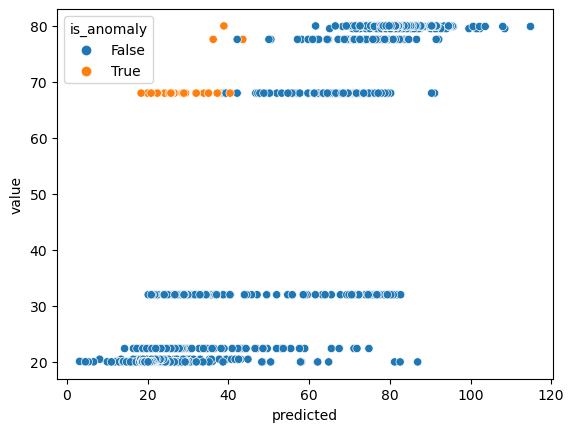

In [9]:
#Visualizing the data points
sns.scatterplot(data = df_test, x='predicted', y='value', hue = 'is_anomaly')

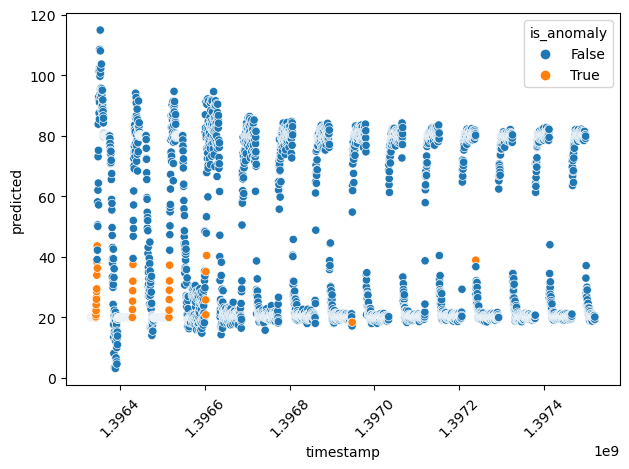

In [11]:
#Visualizing the anomaly cases
sns.scatterplot(data = df_test, x='timestamp', y='predicted', hue = 'is_anomaly')
plt.xticks(rotation = 45)
plt.tight_layout()

<span style= "color: blue">**Conclusion**</span>

This gives by far the best recall score (0.84), which is crucial for the identifying the anomalies.